# Data Collection

In [1]:
import glob
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize as wt
from nltk.stem import PorterStemmer
import os
from lxml import html
import requests
from bs4 import BeautifulSoup
import codecs
import re
import string
import json
from random import randint
import collections
import matplotlib.pyplot as plt
import operator
import seaborn as sns
import math
import numpy as np
from sklearn.cluster import KMeans 
from sklearn.feature_extraction import DictVectorizer
import heapq
from wordcloud import WordCloud

nltk.download('stopwords')
nltk.download('punkt')

path = 'lyrics/'
params = {'apiKey': 'MgUrOqrOhZW1HgX8BEUvwde3nEJHEV7o'}
url = 'https://api.mlab.com/api/1/databases'
response = requests.get(url, params)

[nltk_data] Downloading package stopwords to /Users/Dario/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Dario/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# DON'T RUN THE FOLLOWING CELL, BECAUSE IT'S THE FUNCTION FOR UPLOADING ALL DATA TO MONGODB, TO BE SURE WE PUT A COMMENT FOR THE WHOLE FOLLOWING CELL

In [ ]:
# This function takes songs from local file and put them on MongoDb
'''def extractSong(filename):fhj
    songDict={}
    myFiles = codecs.open(filename,'r',encoding='utf8')
    source_code = myFiles.read()
    
    soup = BeautifulSoup(source_code,"lxml")
    rawLyric = soup.find("div", { "class" : "dn", "id" : "content_h"  })
    #print(rawLyric)
    if(rawLyric is not None):
        lyrics = rawLyric.text
        
    getTitle = soup.find_all("span", { "itemprop":"title"})
    
    if(rawLyric is not None):
        songDict["Title"] = getTitle[2].text 
        songDict["Artist"] = getTitle[1].text
        songDict["Lyrics"] =(re.sub(r"(?<![A-Z])(?<!^)([A-Z])",r" \1",lyrics)).lower() 
        #Above we use regular expression in order to split beginning of new line from last line and,we lowercase all the letters
        #(we areAnd nothing => we are and nothing)
        songDict["URL"] = filename
        localFile.append(songDict)
        repeat=True
        while (repeat):
            try:
                dbname = 'song'
                collection = 'songinfo'
                url = 'https://api.mlab.com/api/1/databases/' + dbname + '/collections/' + collection
                headers = {'content-type': 'application/json'}
                data = json.dumps(songDict)
                response = requests.post(url, data=data, params=params, headers=headers) 
                print(response)
            except:
                print("Error encountered while collecting", songDict)
                pass
            else :
                repeat = False
# Take all songs from local file and save them on MongoDb                
localFile=[]            
for filename in glob.glob(os.path.join(path, '*.html')):
    extractSong(filename)
# Take all songs from local file and save them on local .json file
jsonData = json.dumps(localFile)
with open('localFile.json', 'a') as f:
    f.write(jsonData)     '''     

In [2]:
# This function removes special characters
def removeSpecialChar(string):
    for k in string.split("\n"):
        return (re.sub(r"[^a-zA-Z0-9]+", ' ', k))

# This function counts elements in an object
def Count_things(obj):
    dic={}
    for i in obj:
        dic[i]=dic.get(i,0)+1
    return dic

# This function calculates the cosine similarity between a document and a query
def cosine(Dictquery,Setid,Dicinverted):
    docLen={}
    dotProd={}
    count=0
    heap10=[]
    queryList=[k for k in Dictquery.values()]
    qLenght=math.sqrt(sum(map(lambda x:(x**2),queryList)))
    for docId in Setid:
        score=0
        numerator=0
        cosine=0
        for word in Dicinverted.keys(): 
            for k,v in Dicinverted[word].items():
                if(k==docId):          
                    score+=v**2         
                    docLen[k]=math.sqrt(score)
                    if word in Dictquery.keys():
                        numerator+=Dictquery[word]*v
                        dotProd[docId]=numerator
        cosine=dotProd[docId]/(docLen[docId]*qLenght)
        count+=1
# We create an heap to find the most similar top 10 of the query
        heapq.heappush(heap10,(cosine,docId))
    if count>10:
        test=heapq.nlargest(10,heap10)
    else:
# If top result is less than 10 print all the result 
        test=heapq.nlargest(count,heap10)
    return test

# This function calculates the vector of documents which have all the words of the query
def vectors_text_intersection(Listid,tot_bagofwords,length_query):
    tot_words_inters=set()
    dic=Count_things(Listid)    
    idtext=[]
# This 'for' loops create a tuple with a list with Id of the intersection
# and a set of all words of these documents
    for k,v in dic.items():
# Check if there is an intersection
        if length_query>1 and v>1:
            idtext.append(k)
            for f in tot_bagofwords[k].keys():
                tot_words_inters.add(f)
# Take every document if there is only one word in the query        
        elif length_query==1:
            idtext.append(k)
            for f in tot_bagofwords[k].keys():
                tot_words_inters.add(f)      
        else:
            pass
    values=(idtext,tot_words_inters)
# Create a dictionary which has the id of document(from intersection) as key, and 
# a list with all words inside it as value
    dic_vec={}
    for ind in values[0]:    
        list_vectors=[]
        for word in values[1]:
            if ind in inverted[word].keys():
                for k in inverted[word].keys():
                    if k==ind:
                        list_vectors.append(inverted[word][k])
            if ind not in inverted[word].keys():
                list_vectors.append(0)
        dic_vec[ind]=list_vectors
    return dic_vec

# This function calculates idf for query
def query_idf(lst_query,Dicinverted,length_data):
    Dictquery=Count_things(lst_query)
    for k in Dictquery.keys():
        if k in inverted.keys():
            idf=math.log10(length_data/len(Dicinverted[k]))
        else:
            idf=0
        Dictquery[k]=Dictquery[k]*idf
    return Dictquery

# This function calculates idf for documents
def idf_text(Dicinverted,length_data):
    for k in Dicinverted.keys():
        idf=(math.log10(float(length_data/len(Dicinverted[k]))))
        for v,j in Dicinverted[k].items():
            tf=(math.log10(j))+1
            tfidf=tf*idf
            Dicinverted[k][v]=tfidf 
    
# This function returns a normalized array
def normalize(array):
    return [[lst[num]/np.linalg.norm(lst) for num in range(len(lst))] for lst in array]


# This function Displays wordcloud
def wordcloud(text):
    wordcloud = WordCloud(max_font_size=40).generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [3]:
# Take data from MongoDb
params = {'apiKey': 'MgUrOqrOhZW1HgX8BEUvwde3nEJHEV7o'}
dbname = 'song'
collection = 'songinfo'
url = 'https://api.mlab.com/api/1/databases/' + dbname + '/collections/' + collection+'?l=86480'
headers = {'content-type': 'application/json'}
response = requests.get(url, params)
data = json.loads(response.text)

In [4]:
# List of stopwords
stop_words=stopwords.words('english')+['got','yeah','oh','na','gon']

# Statistics
## Part 1

Lil Wayne
David Bowie


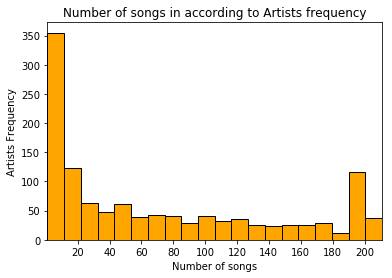

In [6]:
Count_songs = {}
for dic in data:
    Count_songs[dic["Artist"]] = Count_songs.get(dic["Artist"],0)+1
    
# Print artists who have released most songs
[print(i[0]) for i in sorted(Count_songs.items(), key = lambda x: x[1],reverse = True) if i[1] == max(Count_songs.values())]

        
values=[song for song in Count_songs.values()]

# Plot histogram
plt.hist(values,histtype='bar',ec ='black',bins = 20, color="orange")
plt.title("Number of songs in according to Artists frequency")
plt.xlabel("Number of songs")
plt.ylabel("Artists Frequency")
plt.xticks(range(0,211,20))
plt.autoscale(enable=True, axis='x', tight=True)
plt.show()

### The reason why the first two artists of our list are Lil Wayne and David Bowie it could be explained in this way:
### David Bowie started his career in the middle of '60 and his first album released in '65. Since this year till his death (2016), he wrote 25 albums. So it's normal he's in the first position of our list.
### About Lil Wayne, he's a famous rap artist who started to write songs when he was 13. Even if he released "only" 11 albums, we can find something like 20 songs for each album. That could be a good reason why he appears in the first position.

# Statistics
## Part 2

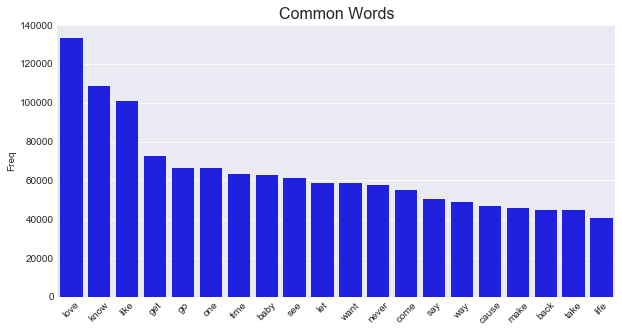

In [7]:
lyricsList = [data[i]['Lyrics'] for i in range(len(data))]
lyricsList = list(map(lambda x: removeSpecialChar(x), lyricsList))


counterLyrics = Count_things([word for l in lyricsList  for word in wt(l) if word not in stop_words and len(word)>1])
sorted_counterLyrics=sorted(counterLyrics.items(), key=lambda x: x[1], reverse=True)[0:20]
values1 = [i[1] for i in sorted_counterLyrics]
names1 = [i[0] for i in sorted_counterLyrics]

# # Plot histogram
sns.set_style("darkgrid")
sns.set_context({"figure.figsize": (10, 5)})
fig, ax = plt.subplots()
sns.barplot(x = names1, y = values1, color = "b")
plt.ylabel("Freq")
plt.title("Common Words", fontsize = 16)
plt.xticks(rotation = 45)
plt.show()

### Excluding some verbs that is gonna be useless to explain (e.g. "get","make","take" and so on)  the most popular words in our list are "love","time","baby","want","life".
### All these words are in included, in our opinion, in a positive sphere about life. The reason  it could be that people like listening songs which refers to a positive part of the life, so that's why the artists release more songs about these topics.

# Statistics
## Part 3

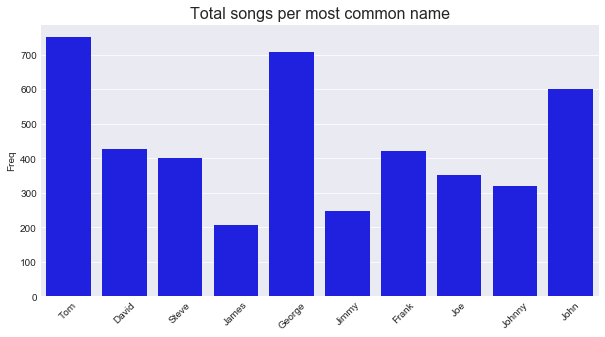

In [8]:
# We put inside our stopwords list 'queen','hillsong' and 'x', because we don't want to take into account the band's names, but only singer's names
# but only artist's name
single_names = [name.split()[0] for name in {dic["Artist"] for dic in data}  if name.split()[0].lower() not in stop_words+['queen','hillsong','x']]
counter_name = Count_things(single_names)
sorted_counter_name = sorted(counter_name.items(), key=lambda x: x[1], reverse=True)[0:10]
dic_name = dict(sorted_counter_name)

name_songs = {}
for key in dic_name.keys():
    for artist,k in Count_songs.items():
        if artist.startswith(key + " "):
            name_songs[key]=name_songs.get(key,0)+k
        
values2 = [i for i in name_songs.values()]
names2 = [i for i in name_songs.keys()]

# Plot histogram
sns.set_style("darkgrid")
sns.set_context({"figure.figsize": (10, 5)})
fig, ax = plt.subplots()
sns.barplot(x = names2, y = values2, color = "b")
plt.ylabel("Freq")
plt.title("Total songs per most common name", fontsize = 16)
plt.xticks(rotation = 45)
plt.show()

# Statistics
## Part 4

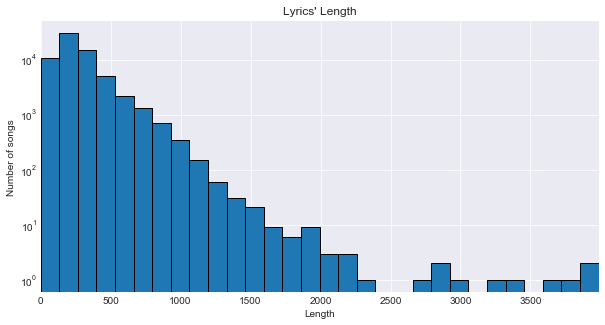

In [9]:
length_lyrics = {dic['Title']:len(wt(dic['Lyrics'])) for dic in data}
values_length_lyrics = [value for value in length_lyrics.values()]

# Plot histogram
# In this histogram we decided to use the log for scaling axis y because we had some outliers values which it was impossible
# to visualize 'cause they were "far" from the avarage of the distribution. 
plt.hist(values_length_lyrics,histtype='bar',ec ='black',bins = 30)
plt.title("Lyrics' Length")
plt.xlabel("Length")
plt.ylabel("Number of songs")
ax.grid(True)
plt.yscale('log', nonposy='clip')
plt.autoscale(enable=True, axis='x', tight=True)
plt.show()

### In the histogram above, we can see how the most songs have an average length less than 1500 words. A reason could be that it's much easier remember a song with a short lyrics respect of another one which has a lyrics with more of 2000 words.... it could be!!
### Another reason we've thought is that the most of songs have a duration time about 3 or 4 minutes. If we consider the instrumental part, the length of the lyrics it could be how the histogram shows us.

# Search Engine
## Index

In [ ]:
ps=PorterStemmer()

myList_text = [data[i]['Lyrics']+' '+data[i]['Artist']+' '+data[i]['Title'] for i in range(len(data))]
myId=[data[i]['_id']['$oid'] for i in range(len(data))]

# List of every text with word's stem, without special characters
lyrics_stem = list(map(lambda x: removeSpecialChar(x), [" ".join(ps.stem(word) for word in text.split(" ")) for text in myList_text]))

# This dictionary has the document's ids as keys and the song's texts as values
doc_songs={myId[i]:lyrics_stem[i] for i in range(len(myId))}

# This dictionary has the document's ids as keys and a counter of words in that song (dictionary) as values.
preinverted={k:Count_things([word for word in wt(v) if word not in stop_words and len(word)>1]) for k,v in doc_songs.items()}

# This list has all words of all songs
vocabulary=list({word for k,v in doc_songs.items() for word in wt(v) if word not in stop_words and len(word)>1})

# This dictionary has the words as keys and a dictionary, which has the document's ids as keys and the frequencies
# of the word in that document, as value
inverted={word:{} for word in vocabulary}
for i in preinverted.keys():
    for v in preinverted[i].keys():
        inverted[v][i]=preinverted[i][v]

idf_text(inverted,len(data))

# Search Engine
## Search type 1

In [19]:
query=input('Search : ')

Search : buongiorno teresa


In [20]:
# Stemming list of words of the query
query_stem=list({ps.stem(i) for i in query.split() if i not in stop_words and len(i)>1})
queryDict=query_idf(query_stem,inverted,len(data))

# List of total words of document with query's words
myList_id=[i for k in queryDict.keys() for i in inverted[k].keys() if k in inverted.keys()]

mySet=set(myList_id)

top=cosine(queryDict,mySet,inverted)
for i in top:
    for k in range(len(data)):
        if(data[k]['_id']['$oid']==i[1]):
            print(data[k]['Lyrics']+'\n\t\t\t\t\t\t by : '+data[k]['Artist'])
            print('-----------------------------------------------------------------------------------------')

buongiorno  teresa  like the sun you brighten up my day  good mornin'  teresa  smile at me an' send me on my way!  you sit by the tower,  the world rushes by,  sell me a flower,  an' straighten my tie!  i'll walk home this evening  through the lonely market place  i'll sleep well,  i'll dream well,  because tomorrow  i can say " buongiorno  teresa"  i love you more each day!   i'll walk home this evening  through the lonely market place  i'll sleep well,  i'll dream well,  because tomorrow  i can say " buongiorno  teresa"  i love you more (  i love you more! ) each day!  teresa!  i love you more each day!  teresa!  i love you more each day!  words and  music by  dick  manning  and  jimmy  lytell
						 by : Perry Como
-----------------------------------------------------------------------------------------
went out on a limb gone too far i broke down at the side of the road stranded at the outskirts and sun's creepin' up baby's in the backseat still fast asleep dreamin' of better days 

# Search Engine
## Search type 2 (Clustering)

In [24]:
try:
    vectors=vectors_text_intersection(myList_id,preinverted,len(query_stem))
# Create a normalized array to cluster our data. The dimension is the length NxM where N is the number of documents
# from intersection and M is the number of total words inside mySet
    feat_vect = normalize(np.array([value for key, value in vectors.items()]))

        # User inputs the number of clusters
    kmeans = KMeans(n_clusters = int(input()), init='k-means++')
    kmeans.fit(feat_vect)
        
#Create a dictionary where the keys are the cluster
    clusterResults = {}
    for key, value in vectors.items():
        if kmeans.predict([vectors[key]])[0] not in clusterResults:
            clusterResults[int(kmeans.predict([vectors[key]])[0])] = [key]
        else:
            clusterResults[int(kmeans.predict([vectors[key]])[0])].append(key)

    print(clusterResults)
except:
        print('The number of cluster is bigger than the number of documents,\nTry again, the number of documents is %s \n' %len(vectors))

2
The number of cluster is bigger than the number of documents,
Try again, the number of documents is 1 



### Wordcloud

Information: ['Perry Como Buongiorno Teresa']


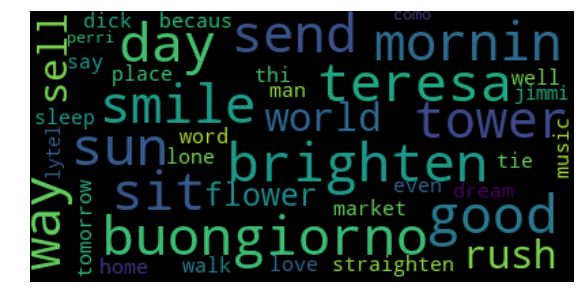

Information: ['Blur People In Europe', 'Leann Rimes Trouble With Goodbye']


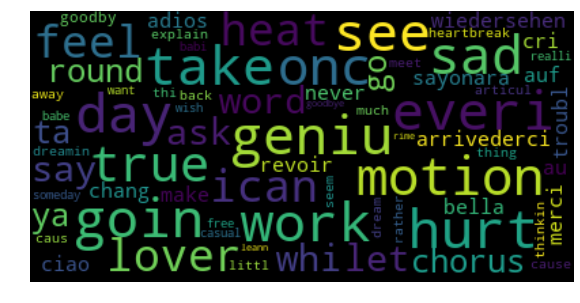

In [31]:
for keys, values in clusterResults.items():
    information = []
    for song in values:
        text=' '.join([i for i in preinverted[song].keys()])
        for k in range(len(data)):
            if data[k]['_id']['$oid']==song:               
                information.append(data[k]['Artist']+' '+data[k]['Title'])
    print("Information:", information )
    wordcloud(text)